<a href="https://colab.research.google.com/github/Brokencarer/hood_4_bar_cost/blob/main/hood_4_bar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
from scipy.optimize import fsolve
import numpy as np
from sympy import *
import sympy as sp
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [ ]:
pi = math.pi
def func(x,params):
    x1 = x
    l11,l22,l33,l44,gamma1,theta_r = params
    l55 = math.sqrt(l11**2+l44**2-2*l11*l44*math.cos(x1))
    alpha = math.acos((l44**2 + l55**2 - l11**2)/(2*l44*l55))
    beta = math.acos((l55**2 + l33**2 - l22**2)/(2*l55*l33))
    sum_angle = x + alpha +beta
    return find_fourbar(l11,l22,l33,l44,gamma1)-sum_angle-theta_r

#--------------------------------------------------------------


#---------------------------------------------------------------All four bar linkage functions in this block
def cal_dist(p1,p2):
    distx = (p1[0]-p2[0])**2
    distz = (p1[1]-p2[1])**2
    return math.sqrt(distx+distz)

#------------------------------------------------------

#------------------------------------------------------
def find_fourbar(l1, l2, l3, l4, gamma):
    l5 = math.sqrt(l1**2+l4**2-2*l1*l4*math.cos(gamma))
    alpha = math.acos((l4**2 + l5**2 - l1**2)/(2*l4*l5))
    beta = math.acos((l5**2 + l3**2 - l2**2)/(2*l5*l3))
    sum_angle = gamma + alpha +beta
    return sum_angle

#-----------------------------------------------------------------------------------------# all points in form of 1*2 list

#-----------------------------------------------------------------------------------------# all points in form of 1*2 list
def find_angle(p1,p2,p3,p4,theta): #p1-p4 means original point, old point, theta: open angle
    theta = theta/180*pi
    l1 = cal_dist(p1,p2)
    l2 = cal_dist(p2,p3)
    l3 = cal_dist(p3,p4)
    l4 = cal_dist(p4,p1)
    gamma1 = math.atan((p4[1]-p1[1])/(p4[0]-p1[0])) - math.atan((p2[1]-p1[1])/(p2[0]-p1[0]))
    params = [l1,l2,l3,l4,gamma1,theta]

    gamma2 = fsolve(func , [gamma1+0.01*theta], xtol=1.49012e-10,args=params)

    abs_slope_l3 = pi - math.atan((p2[1]-p1[1])/(p2[0]-p1[0])) - find_fourbar(l1,l2,l3,l4,gamma2)
    p4_new = np.array([l4*math.cos(gamma2 + math.atan((p2[1]-p1[1])/(p2[0]-p1[0]))),l4*math.sin(gamma2 + math.atan((p2[1]-p1[1])/(p2[0]-p1[0])))])+np.array(p1)
    p3_new = np.array([l3*math.cos(abs_slope_l3),-l3*math.sin(abs_slope_l3)])+np.array(p4_new)
    return abs_slope_l3, p4_new,gamma1,gamma2,p3_new
#----------------------------------------------------------------------------------------------------
def calc_abc_from_line_2d(x0, y0, x1, y1):
    a = y0 - y1
    b = x1 - x0
    c = x0*y1 - x1*y0
    return a, b, c

def get_line_cross_point(line1, line2):
    # x1y1x2y2
    a0, b0, c0 = calc_abc_from_line_2d(*line1)
    a1, b1, c1 = calc_abc_from_line_2d(*line2)
    D = a0 * b1 - a1 * b0
    if D == 0:
        return None
    x = (b0 * c1 - b1 * c0) / D
    y = (a1 * c0 - a0 * c1) / D
    # print(x, y)
    return [x, y]

def find_axis(p1,p2,p3,p4):
    p_ax = get_line_cross_point(np.concatenate([p1,p2],axis = 0), np.concatenate([p3,p4], axis = 0))
    return p_ax
#----------------------------------------------------------------------------

def find_all_p(p1, p2,p3, p4,p5, angle):
    slope, p4_new, gamma1, gamma2, p3_new = find_angle(p1,p2,p3,p4,angle)
    p5_new = find_newpoint(p5, p4, p4_new, angle)
    p_axis = find_axis(p1,p4_new,p2,p3_new)
    return p3_new, p4_new, p5_new, p_axis

#-------------------------------------------------------------------------
def find_newpoint(p_old,p4_old,p4_new,theta): #theta counter_clockwise
    theta_r = theta/180*pi
    rotation_matrix = np.array([[math.cos(theta_r), -math.sin(theta_r)],[math.sin(theta_r), math.cos(theta_r)]]) #点*旋转矩阵
    p_n = p4_new + np.dot(np.array(p_old) - np.array(p4_old), rotation_matrix)
    return p_n
#----------------------------------------------------------------------------
def reinf_length(p4_old,p5_old):
    p4x, p4z, p5x, p5z = symbols('p4x, p4z, p5x, p5z')
    disx = p4x - p5x
    disz = p4z - p5z
    dis_45 = sqrt(disx**2 +disz**2)  #reinf length
    dis_diff4 = [diff(dis_45, p4x), diff(dis_45, p4z)]
    dis_diff5 = [diff(dis_45, p5x), diff(dis_45, p5z)]
    dis_diff4 = [i.subs({p4x:p4_old[0] ,p4z:p4_old[1], p5x:p5_old[0],p5z:p5_old[1]}).evalf(6) for i in dis_diff4]
    dis_diff5 = [i.subs({p4x:p4_old[0] ,p4z:p4_old[1], p5x:p5_old[0],p5z:p5_old[1]}).evalf(6) for i in dis_diff5]
    gradient = np.concatenate([dis_diff4, dis_diff5], axis=0)
    gradient = np.concatenate([[0 for i in range(6)],gradient,[0,0] ], axis=0)
    cvalue = dis_45.subs({p4x:p4_old[0] ,p4z:p4_old[1], p5x:p5_old[0],p5z:p5_old[1]}).evalf(6)
    return gradient, cvalue
#-----------------------------------------------------------------------------------
def pot_length(p5_old,p6_old):
    p5x, p5z, p6x, p6z = symbols('p5x, p5z, p6x, p6z')
    disx = p5x - p6x
    disz = p5z - p6z
    dis_56 = sqrt(disx**2 +disz**2)  #reinf length
    dis_diff5 = [diff(dis_56, p5x), diff(dis_56, p5z)]
    dis_diff6 = [diff(dis_56, p6x), diff(dis_56, p6z)]
    dis_diff5= [i.subs({p5x:p5_old[0] ,p5z:p5_old[1], p6x:p6_old[0],p6z:p6_old[1]}).evalf(6) for i in dis_diff5]
    dis_diff6 = [i.subs({p5x:p5_old[0] ,p5z:p5_old[1], p6x:p6_old[0],p6z:p6_old[1]}).evalf(6) for i in dis_diff6]
    gradient = np.concatenate([dis_diff5, dis_diff6], axis=0)
    gradient = np.concatenate([[0 for i in range(8)],gradient ], axis=0)
    cvalue = dis_56.subs({p5x:p5_old[0],p5z:p5_old[1], p6x:p6_old[0],p6z:p6_old[1]}).evalf(6)
    return gradient, cvalue
#-----------------------------------------------------------------------------------
def moment_length(p4_old,p5_old,l_hood):
    p4x, p4z, p5x, p5z = symbols('p4x, p4z, p5x, p5z')
    disx = p4x - p5x
    disz = p4z - p5z
    dis_45 = sqrt(disx**2 +disz**2)  #reinf length
    cost_f = sqrt((dis_45/l_hood-0.75)**2)
    diff_4 = [diff(cost_f, p4x),diff(cost_f, p4z)]
    diff_5 = [diff(cost_f, p5x),diff(cost_f, p5z)]
    diff_4 = [i.subs({p4x:p4_old[0] ,p4z:p4_old[1], p5x:p5_old[0],p5z:p5_old[1]}).evalf(6) for i in diff_4]
    diff_5 = [i.subs({p4x:p4_old[0] ,p4z:p4_old[1], p5x:p5_old[0],p5z:p5_old[1]}).evalf(6) for i in diff_5]
    gradient = np.concatenate([diff_4, diff_5], axis=0)
    gradient = np.concatenate([[0 for i in range(6)],gradient,[0,0] ], axis=0)
    cvalue = cost_f.subs({p4x:p4_old[0] ,p4z:p4_old[1], p5x:p5_old[0],p5z:p5_old[1]}).evalf(6)
    return gradient,cvalue

#------------------------------------------------------------------------------

def angle_pole(p1_old, p2_old, p3_old, p4_old):
    p1x, p1z, p2x, p2z, p3x, p3z, p4x, p4z, p5x, p5z = symbols('p1x, p1z, p2x, p2z, p3x, p3z, p4x, p4z, p5x, p5z')
    vector1 = [p4x - p1x, p4z - p1z]
    vector2 = [p3x-p2x, p3z-p2z]
    cos_angle = (vector1[0]*vector2[0]+vector1[1]*vector2[1])/(sqrt(vector1[0]**2+vector1[1]**2)*sqrt(vector2[0]**2+vector2[1]**2))
    angle_gap = sqrt((acos(cos_angle)/pi*180 - 20)**2)
    diff
    return

In [ ]:
def cal_elongation(p_5,p_6,p5_new):
    elong = np.linalg.norm(np.array(p5_new) - np.array(p_6)) - np.linalg.norm(np.array(p_5) - np.array(p_6))
    rate = np.linalg.norm(np.array(p5_new) - np.array(p_6)) / np.linalg.norm(np.array(p_5) - np.array(p_6))
    return elong, rate
#----------------------------------------------------------------------------------------------------------------------------------
def check_l_eligibility(p_5,p_6,p5_new):
    #calculate
    flag = True
    elongation, tensile_rate = cal_elongation(p_5,p_6,p5_new)

    #judgement
    if elongation > elong_max or tensile_rate > tensile_rate_max:
        flag = False
    return flag
#------------------------------------------------------------------------------------------------------------------------------------




In [ ]:
import sympy as sp
def get_distance_from_point_to_line(x_axis, z_axis, x_body_point, z_body_point, x_tailgate_point, z_tailgate_point):
    A = z_tailgate_point - z_body_point
    B = x_body_point - x_tailgate_point
    C = (z_body_point - z_tailgate_point) * x_body_point + (x_tailgate_point - x_body_point) * z_body_point
    distance = sp.Abs(A * x_axis + B * z_axis + C) / sp.sqrt(A**2 + B**2)
    return distance


def spring_parameter(p_body,p_gate , p_mass , total_weight_tailgate_kg, open_angle):
    ##x_body_point,zbp = p6      xtp,ztp =p5
    x_body_point, z_body_point = p_body[0], p_body[1]
    x_tailgate_point, z_tailgate_point = p_gate[0], p_gate[1]
    x_center_gravity_tailgate, z_center_gravity_tailgate = p_mass[0], p_mass[1]
    #pi = sp.pi
    open_angle = open_angle

    p5x, p5z = sp.symbols('p5x p5z',real=True)
    p6x, p6z = sp.symbols('p6x p6z',real=True)
    p7x, p7z = sp.symbols('p7x p7z',real=True)

    p1 = p1_initial
    p2 = p2_initial
    p3 = p3_initial
    p4 = p4_initial
    p5 = [p5x, p5z]  #gate point
    p6 = [p6x, p6z] #body point
    p7 = [p7x, p7z] #center of mass
    deriv = [0,0,0,0,0,0,0,0]
    k_array = []
    for i in range(9):
        ps = np.concatenate([p1, p2,p3, p4], axis =0)
        if i !=0 :
            ps[i-1] = ps[i-1]+0.000001
        p1 = [ps[0], ps[1]]
        p2 = [ps[2], ps[3]]
        p3 = [ps[4], ps[5]]
        p4 = [ps[6], ps[7]]

        x_axis,z_axis = find_all_p(p1, p2, p3, p4, p5, open_angle)[3][0:2]
        x_axis_cl,z_axis_cl = find_all_p(p1, p2, p3, p4, p5, 0)[3][0:2]

        x_close_handle_point, z_close_handle_point = - 850 ,  400
        x_open_handle_point, z_open_handle_point = - 850 , 1700

        arm_of_force_hand_close = sp.sqrt((x_close_handle_point - x_axis_cl)**2 + (z_close_handle_point - z_axis_cl)**2)
        arm_of_force_hand_open = sp.sqrt((x_open_handle_point - x_axis)**2 + (z_open_handle_point - z_axis)**2)

        find_ang_1 = find_angle(p1,p2,p3,p4,open_angle)[1]
        find_ang_0 = find_angle(p1,p2,p3,p4,0)[1]

        uphill_x_center_gravity_open = find_newpoint(p7, p4,find_ang_1, open_angle-11.3)[0]
        downhill_x_center_gravity_open = find_newpoint(p7, p4,find_ang_1, open_angle+11.3)[0]
        uphill_x_center_gravity_close = find_newpoint(p7, p4,find_ang_0, -11.3)[0]
        downhill_x_center_gravity_close = find_newpoint(p7, p4,find_ang_0, 11.3)[0]
        x_tailgate_point_opened, z_tailgate_point_opened = find_newpoint(p5, p4,find_angle(p1,p2,p3,p4,open_angle)[1], open_angle)


        uphill_weight_moment_open = -(total_weight_tailgate_kg * (uphill_x_center_gravity_open - x_axis) * 10)
        downhill_weight_moment_open = -(total_weight_tailgate_kg * (downhill_x_center_gravity_open - x_axis) * 10)
        uphill_weight_moment_close = -(total_weight_tailgate_kg * (uphill_x_center_gravity_close - x_axis_cl) * 10)
        downhill_weight_moment_close = -(total_weight_tailgate_kg * (downhill_x_center_gravity_close - x_axis_cl) * 10)

        uphill_hold_moment_openposition = (uphill_weight_moment_open + 15 * arm_of_force_hand_open) / (1 - 0.06)
        downhill_open_avoid_openposition = downhill_weight_moment_open / 1.06
        target_moment_openposition = (uphill_hold_moment_openposition + downhill_open_avoid_openposition) / 2

        uphill_open_avoid_closeposition = (uphill_weight_moment_close - 12 * arm_of_force_hand_close) / 1.06
        downhill_hold_moment_closeposition = (downhill_weight_moment_close + 5 * arm_of_force_hand_close) / (1 - 0.06)
        target_moment_closeposition = (uphill_open_avoid_closeposition + downhill_hold_moment_closeposition) / 2

        arm_of_force_openposition = get_distance_from_point_to_line(x_axis, z_axis, p6x, p6z, x_tailgate_point_opened, z_tailgate_point_opened)
        spring_force_openposition = target_moment_openposition / arm_of_force_openposition / 2

        arm_of_force_closeposition = get_distance_from_point_to_line(x_axis_cl, z_axis_cl, p6x, p6z, p5x, p5z)
        spring_force_closeposition = target_moment_closeposition / arm_of_force_closeposition / 2

        extend_length = sp.sqrt((x_tailgate_point_opened - p6x)**2 + (z_tailgate_point_opened - p6z)**2) - sp.sqrt((p5x - p6x)**2 + (p5z - p6z)**2)
        k_index_spring = (spring_force_closeposition - spring_force_openposition) / extend_length
        k_array.append(k_index_spring.subs({p5x:x_tailgate_point ,p5z:z_tailgate_point, p6x:x_body_point, p6z:z_body_point,  p7x:x_center_gravity_tailgate,p7z:z_center_gravity_tailgate}).evalf(8))
        if i == 0:
            k_std = k_index_spring
        else:
            deriv[i-1] = (k_index_spring-k_std)/0.000001

    deriv = [deriv[i].subs({p5x:x_tailgate_point ,p5z:z_tailgate_point, p6x:x_body_point, p6z:z_body_point,  p7x:x_center_gravity_tailgate,p7z:z_center_gravity_tailgate}).evalf(8) for i in range(8)]

    k = sp.Matrix([k_std])
    dif = k.jacobian([p5x,p5z,p6x,p6z,p7x,p7z])
    kvalue = k_std.subs({p5x:x_tailgate_point ,p5z:z_tailgate_point, p6x:x_body_point, p6z:z_body_point,  p7x:x_center_gravity_tailgate,p7z:z_center_gravity_tailgate}).evalf(8)
    #kvalue1 = k_index_spring.subs({p5x:x_tailgate_point+0.0001 ,p5z:z_tailgate_point, p6x:x_body_point, p6z:z_body_point,  p7x:x_center_gravity_tailgate,p7z:z_center_gravity_tailgate}).evalf(8)
    dif_value = dif.subs({p5x:x_tailgate_point ,p5z:z_tailgate_point, p6x:x_body_point, p6z:z_body_point,  p7x:x_center_gravity_tailgate,p7z:z_center_gravity_tailgate}).evalf(6)
    dif5 = Derivative(k_index_spring, p5x).subs({p5x:x_tailgate_point,p5z:z_tailgate_point, p6x:x_body_point, p6z:z_body_point,  p7x:x_center_gravity_tailgate,p7z:z_center_gravity_tailgate})

    param = [x_tailgate_point, z_tailgate_point,x_body_point, z_body_point,  x_center_gravity_tailgate, z_center_gravity_tailgate]
    extend_length1 = extend_length.subs({p5x:x_tailgate_point ,p5z:z_tailgate_point, p6x:x_body_point, p6z:z_body_point,  p7x:x_center_gravity_tailgate,p7z:z_center_gravity_tailgate}).evalf(6)
    for i in range(4):
        k_array.append(kvalue + np.array(dif_value)[0][i]*0.000001)

    return -kvalue,-np.concatenate( [deriv , np.array(dif_value)[0] ], axis = 0)[0:12], -np.array(k_array)


In [ ]:
#stiffness = spring_parameter([-345, 569], [0, 790], [-494,730], 21, 40)
#stiffness

In [ ]:

def force_different_angle(total_weight_tailgate_kg, pts, stiff_input_no):
    #算F1 L1 L2
    #算 F2 根据 伸长量和k
    angle_list = [max_angle/5*i for i in range(6)]
    force_list, force_gap_list = [],[]
    pt1,pt2,pt3,pt4,pt5,pt6,pt7 = pts[0:2],pts[2:4],pts[4:6],pts[6:8],pts[8:10],pts[10:12],pts[12:14]
    flag = True
    for theta in angle_list:
        x_axis, z_axis = find_all_p(pt1, pt2, pt3, pt4, pt5, theta)[3][0:2]
        mass_x = find_newpoint(pt7, pt4,find_angle(pt1,pt2,pt3,pt4,theta)[1], theta)[0]
        p5_n = find_newpoint(pt5, pt4,find_angle(pt1,pt2,pt3,pt4,theta)[1], theta)
        #x_tailgate_point_opened, z_tailgate_point_opened = find_newpoint(p5, p4,find_angle(p1,p2,p3,p4,open_angle)[1], open_angle)
        dis_force = get_distance_from_point_to_line(x_axis, z_axis, pt6[0], pt6[1], p5_n[0], p5_n[1])
        dis_mass_x = -mass_x + x_axis
        force = total_weight_tailgate_kg*9.8*dis_mass_x/dis_force/2
        force_list.append(force.evalf())
        p5_new = find_all_p(pt1, pt2,pt3, pt4,pt5, theta)[2]
        delta_length = cal_elongation(pt5,pt6,p5_new)[0]
        #stiffness = spring_parameter(p6_initial, p5_initial, p7_initial, total_weight_tailgate_kg, max_angle)

        force_gap = force_list[0] - delta_length*stiff_input_no - force.evalf()
        force_gap_list.append(force_gap)
        if theta > 5 and force_list[0]/1.5-(force_list[-1]/(1.5-0.01*theta))>550:
            flag = False
    return force_list, force_gap_list, flag

def cal_force_deriv(total_weight_tailgate_kg, pts, stiff_input):
    deriv = [0 for i in range(12)]
    pt_var = [i for i in pts]
    pt1,pt2,pt3,pt4,pt5,pt6,pt7 = pts[0:2],pts[2:4],pts[4:6],pts[6:8],pts[8:10],pts[10:12],pts[12:14]
    for i in range(13):
        if i !=0:
            pt_var[i-1] = pts[i-1]+0.000001
        force_list,force_gap_list, flag = force_different_angle(total_weight_tailgate_kg, pt_var, stiff_input[i])
        mean_force = sum(force_list)/len(force_list)
        force_gap_max = max(force_gap_list)
        economy = force_gap_max*0.02*25 + mean_force*0.0032*25
        if i == 0:
            economy_std = economy
        else:
            deriv[i-1] = (economy-economy_std)/0.000001
    return economy_std, deriv, flag


In [ ]:
def generate_random_points(polygon, num_points):
    #存储点
    random_points = []
    random_xs = []
    random_ys = []
    while len(random_points) < num_points:
        #生成随机坐标
        min_x, min_y, max_x, max_y = polygon.bounds
        random_x = np.random.uniform(min_x, max_x)
        random_y = np.random.uniform(min_y, max_y)
        random_point = Point(random_x, random_y)
        if polygon.contains(random_point):
            random_xs.append(random_x)
            random_ys.append(random_y)
            random_points.append(random_point)
    return random_xs, random_ys

points = [0 for i in range(6)]
polygon_1 =  Polygon([(100,770),(115,770),(115,782),(100,782)])
polygon_2 =  Polygon([(173, 770),(180,770),(180,780),(173,780)])
polygon_3 =  Polygon([(255,825),(265,825),(265,835),(255,835)])
polygon_4 =  Polygon([(220,825),(233,825),(233,835),(221,825)])
polygon_5 =  Polygon([(-5,785),(5,785),(5,795),(-8,796)])
polygon_6 =  Polygon([(-352,563),(-336,563),(-336,578),(-353,579)])
polygons = [polygon_1, polygon_2, polygon_3, polygon_4,polygon_5, polygon_6]
initial_points = pd.DataFrame( )
number_initial_points = 8
for i in range(6):
    points[i] = generate_random_points(polygons[i], number_initial_points)
    initial_points[2*i],initial_points[2*i+1] = points[i][0],points[i][1]

initial_points


,0,1,2,3,4,5,6,7,8,9,10,11
0,112.467022,774.102835,177.272587,774.552433,257.301258,832.554060,232.583572,826.063417,-0.950738,791.925043,-336.148660,570.593917
1,110.163550,778.214750,178.206220,775.836874,258.501696,830.449985,226.786713,829.525234,0.807082,792.629324,-336.825231,573.890681
2,108.480976,781.370334,178.656681,779.975308,260.538665,832.434975,228.772863,827.426654,0.001646,788.729979,-343.367173,567.412888
3,114.086362,781.341731,177.518050,779.033774,257.759736,830.753113,225.073932,826.411046,-1.163251,786.941860,-351.348579,573.548953
4,111.956871,776.581653,174.267565,777.415992,261.002963,834.272855,231.847370,832.913232,2.072171,794.975451,-344.065871,569.592673
5,104.121232,775.772652,178.490622,772.697517,256.983019,830.236462,228.917011,829.953300,-4.380147,786.001536,-337.899159,566.527972
6,105.914668,779.017957,176.739175,772.116918,258.958869,826.648185,223.048458,825.049150,4.405520,788.944979,-336.065433,575.775246
7,107.183665,780.171483,175.025886,772.383541,261.832680,831.236332,226.822441,829.082726,2.517736,793.341155,-349.093389,572.314190


In [ ]:

max_angle = 45
gate_mass = 21
p1_initial = [107.977,777.043]
p2_initial = [177,775]
p3_initial = [262,829]
p4_initial = [226, 830]
p5_initial = [1, 790]  # gate point
p6_initial = [-345, 569]  # body point
p7_initial = [-494,730] #mass center point
point_all = np.concatenate([p1_initial,p2_initial,p3_initial,p4_initial,p5_initial,p6_initial,p7_initial],axis = 0)
hood_length = 1000
elong_max = 200
tensile_rate_max = 3


def cal_economy(max_angle, gate_mass):
    gradient_reinf, eco_reinf = reinf_length(p4_initial,p5_initial)
    gradient_pot_length, eco_pot_length = pot_length(p5_initial,p6_initial)
    gradient_moment_length, eco_moment_length = moment_length(p4_initial,p5_initial,hood_length)
    p5_final = find_all_p(p1_initial, p2_initial,p3_initial, p4_initial,p5_initial, max_angle)[2]
    flag_length = check_l_eligibility(p5_initial,p6_initial,p5_final)
    eco_spring, gradient_spring, stiff_array = spring_parameter(p6_initial,p5_initial , p7_initial , gate_mass , max_angle)

    eco_force, gradient_force, flag_force = cal_force_deriv(gate_mass,point_all, stiff_array)

    gradient_sum = np.array([gradient_reinf,gradient_pot_length, gradient_moment_length, gradient_spring, gradient_force]).sum(axis = 0)

    gradient = np.array([gradient_reinf,gradient_pot_length, gradient_moment_length, gradient_spring, gradient_force])

    cost_df = pd.DataFrame([eco_reinf, eco_pot_length, eco_moment_length, eco_spring, eco_force])

    flag_economy = True
    if flag_force == False:
        flag_economy = 'Force gap limit 550'
    elif flag_length == False:
        flag_economy = 'Elongation limit exceeds'

    return sum([eco_reinf, eco_pot_length, eco_moment_length, eco_spring, eco_force]), gradient_sum, flag_economy

cal_economy(max_angle, gate_mass)

#eco_spring, gradient_spring, stiff_array = spring_parameter(p6_initial,p5_initial , p7_initial , gate_mass , max_angle)
#cal_force_deriv(gate_mass,point_all, stiff_array)

(1171.44497707143,
 array([2.27473273722717, -3.65627360054350, -2.25834811228560,
        -3.06540562878945, -5.21277237623872, -4.79857019849442,
        -7.60176335393771, 4.63576205926074, 9.11541489213414,
        -7.04764696978964, -5.03901954619505, 2.72877579322085],
       dtype=object),
 True)

In [ ]:
max_angle = 45
gate_mass = 30
p1_initial = [107.777,777.043]
p2_initial = [177,775]
p3_initial = [261,829]
p4_initial = [226, 830]
p5_initial = [0, 790]  # gate point
p6_initial = [-345, 569]  # body point
p7_initial = [-494,730] #mass center point
point_all = np.concatenate([p1_initial,p2_initial,p3_initial,p4_initial,p5_initial,p6_initial,p7_initial],axis = 0)
hood_length = 1000
elong_max = 200
tensile_rate_max = 3
number_of_trials = 5
gradient_arrays = [pd.DataFrame([[0 for i in range(12)]], columns = ['p1x','p1y','p2x','p2y','p3x','p3y','p4x','p4y','p5x','p5y','p6x','p6y']) for j in range(number_of_trials)]
value_arrays = [pd.DataFrame([[0 for i in range(13)]], columns = ['cost','p1x','p1y','p2x','p2y','p3x','p3y','p4x','p4y','p5x','p5y','p6x','p6y']) for j in range(number_of_trials)]
check_lists = [pd.DataFrame([[0 for i in range(2)]], columns = ['Flag', 'Outliers']) for j in range(number_of_trials)]

for no_iteration in range(number_of_trials):
    p1_initial = [initial_points.iloc[no_iteration,0],initial_points.iloc[no_iteration,1]]
    p2_initial = [initial_points.iloc[no_iteration,2],initial_points.iloc[no_iteration,3]]
    p3_initial = [initial_points.iloc[no_iteration,4],initial_points.iloc[no_iteration,5]]
    p4_initial = [initial_points.iloc[no_iteration,6],initial_points.iloc[no_iteration,7]]
    p5_initial = [initial_points.iloc[no_iteration,8],initial_points.iloc[no_iteration,9]]
    p6_initial = [initial_points.iloc[no_iteration,10],initial_points.iloc[no_iteration,11]]
    point_all = np.concatenate([p1_initial,p2_initial,p3_initial,p4_initial,p5_initial,p6_initial,p7_initial],axis = 0)
    for i in range(30):
        #update iteration
        try:
            cost_new, gradient_new, flag_economy = cal_economy(max_angle,gate_mass)
        except:
            check_lists[no_iteration].loc[i+1,'Flag'] = 'four bar exist error'
            break
        gradient_new = gradient_new.astype(float)
        point_all = point_all - np.concatenate([gradient_new, [0,0]], axis = 0)*0.05
        p1_initial, p2_initial, p3_initial, p4_initial, p5_initial, p6_initial = point_all[0:2],point_all[2:4],point_all[4:6],point_all[6:8],point_all[8:10] ,point_all[10:12]

        #update plot data
        gradient_arrays[no_iteration].loc[i+1] = gradient_new
        value_arrays[no_iteration].loc[i+1] = np.concatenate([[cost_new], point_all[0:12]], axis = 0)
        check_lists[no_iteration].loc[i+1,'Flag'] = flag_economy
        check_lists[no_iteration].loc[i+1,'Check 3-4 length'] = cal_dist(p3_initial, p4_initial)>30
        print([no_iteration,i])

In [ ]:
number_of_trial = 1
gradient_arrays[number_of_trial]

,p1x,p1y,p2x,p2y,p3x,p3y,p4x,p4y,p5x,p5y,p6x,p6y
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.301448,-4.081914,-1.632896,-2.696766,-6.893790,-6.292411,-7.573598,6.037598,12.036487,-9.148169,-5.863001,3.483937
2,0.679183,-3.943814,-1.540161,-2.576820,-6.746679,-6.088533,-6.762470,5.920347,11.546095,-8.729619,-5.605265,3.281327
3,0.622255,-2.693054,-0.895187,-1.903367,-6.627545,-5.363103,-5.420667,5.816869,11.112315,-8.361160,-5.380232,3.103589
4,0.281745,-2.891086,-0.541932,-1.812190,-6.542060,-5.547830,-4.976927,5.725485,10.730326,-8.039853,-5.188842,2.950124
5,-0.064249,-2.818288,-0.480383,-1.728471,-6.475398,-5.766278,-4.551531,5.643511,10.382328,-7.748749,-5.014877,2.810525
6,-0.122382,-2.758379,-0.131536,-1.358171,-6.424735,-5.429549,-4.143558,5.569906,10.064784,-7.484571,-4.856431,2.683260
7,-0.474744,-2.709946,-0.078259,-1.286083,-6.389724,-5.699459,-3.749821,5.502641,9.771743,-7.242760,-4.712227,2.566808
8,-0.537053,-2.671751,-0.027424,-1.218123,-6.369740,-5.699372,-3.367698,5.441993,9.501349,-7.021330,-4.579340,2.459374
9,-0.900816,-2.342384,0.321142,-0.854837,-6.362942,-5.716986,-2.994465,5.086848,9.249774,-6.817155,-4.456601,2.359824


In [ ]:
value_arrays[number_of_trial]

,cost,p1x,p1y,p2x,p2y,p3x,p3y,p4x,p4y,p5x,p5y,p6x,p6y
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1354.50015914437,110.098478,778.418846,178.287865,775.971712,258.846385,830.764606,227.165393,829.223354,0.205258,793.086733,-336.532081,573.716484
2,1333.77688880254,110.064519,778.616036,178.364873,776.100553,259.183719,831.069033,227.503516,828.927336,-0.372047,793.523214,-336.251818,573.552418
3,1315.05170436616,110.033406,778.750689,178.409632,776.195721,259.515096,831.337188,227.774550,828.636493,-0.927663,793.941272,-335.982806,573.397238
4,1298.05122344545,110.019319,778.895243,178.436729,776.286331,259.842199,831.614579,228.023396,828.350219,-1.464179,794.343264,-335.723364,573.249732
5,1282.24875085542,110.022531,779.036158,178.460748,776.372754,260.165969,831.902893,228.250973,828.068043,-1.983295,794.730702,-335.472620,573.109206
6,1267.53434072931,110.028650,779.174077,178.467325,776.440663,260.487206,832.174371,228.458151,827.789548,-2.486535,795.104930,-335.229799,572.975043
7,1253.70610057025,110.052388,779.309574,178.471238,776.504967,260.806692,832.459344,228.645642,827.514416,-2.975122,795.467068,-334.994187,572.846703
8,1240.66574071705,110.079240,779.443162,178.472609,776.565873,261.125179,832.744312,228.814027,827.242316,-3.450189,795.818135,-334.765220,572.723734
9,1228.29197807432,110.124281,779.560281,178.456552,776.608615,261.443326,833.030162,228.963750,826.987974,-3.912678,796.158993,-334.542390,572.605743


In [ ]:
check_lists[number_of_trial]

,Flag,Outliers,Check 3-4 length
0,0.0,0.0,NaN
1,True,NaN,True
2,True,NaN,True
3,True,NaN,True
4,True,NaN,True
5,True,NaN,True
6,True,NaN,True
7,True,NaN,True
8,True,NaN,True
9,True,NaN,True


In [ ]:
n = 2
#p1 = value_arrays[number_of_trial].iloc[n, 0:2]
p1 = list(value_arrays[number_of_trial].iloc[n, 1:3])
p2 = list(value_arrays[number_of_trial].iloc[n, 3:5])
p3 = list(value_arrays[number_of_trial].iloc[n, 5:7])
p4 = list(value_arrays[number_of_trial].iloc[n, 7:9])
p_5 = [-494,730]
p6 = list(value_arrays[number_of_trial].iloc[n, 9:11]) #gate
p7 = list(value_arrays[number_of_trial].iloc[n, 11:13]) #body
a1x, a1y, a2x, a2y,a3x, a3y, a4x, a4y ,a5x, a5y,axx,axy, abx,aby,agx,agy= [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
for theta in range(45):
    result = find_all_p(p1, p2, p3, p4,p_5, theta)
    result2 = find_all_p(p1, p2, p3, p4,p6, theta)
    a1x.append(p1[0])
    a1y.append(p1[1])
    a2x.append(p2[0])
    a2y.append(p2[1])
    a3x.append(result[0][0])
    a3y.append(result[0][1])
    a4x.append(result[1][0])
    a4y.append(result[1][1])
    a5x.append(result[2][0])
    a5y.append(result[2][1])
    axx.append(result[3][0])
    axy.append(result[3][1])
    abx.append(p7[0])
    aby.append(p7[1])
    agx.append(result2[2][0])
    agy.append(result2[2][1])

apx = [a1x, a2x,a3x, a4x, a1x ]
apy = [a1y, a2y,a3y, a4y, a1y ]
appx = [axx,a4x,a5x]
appy = [axy, a4y, a5y]
aqx = [abx, agx]
aqy = [aby, agy]

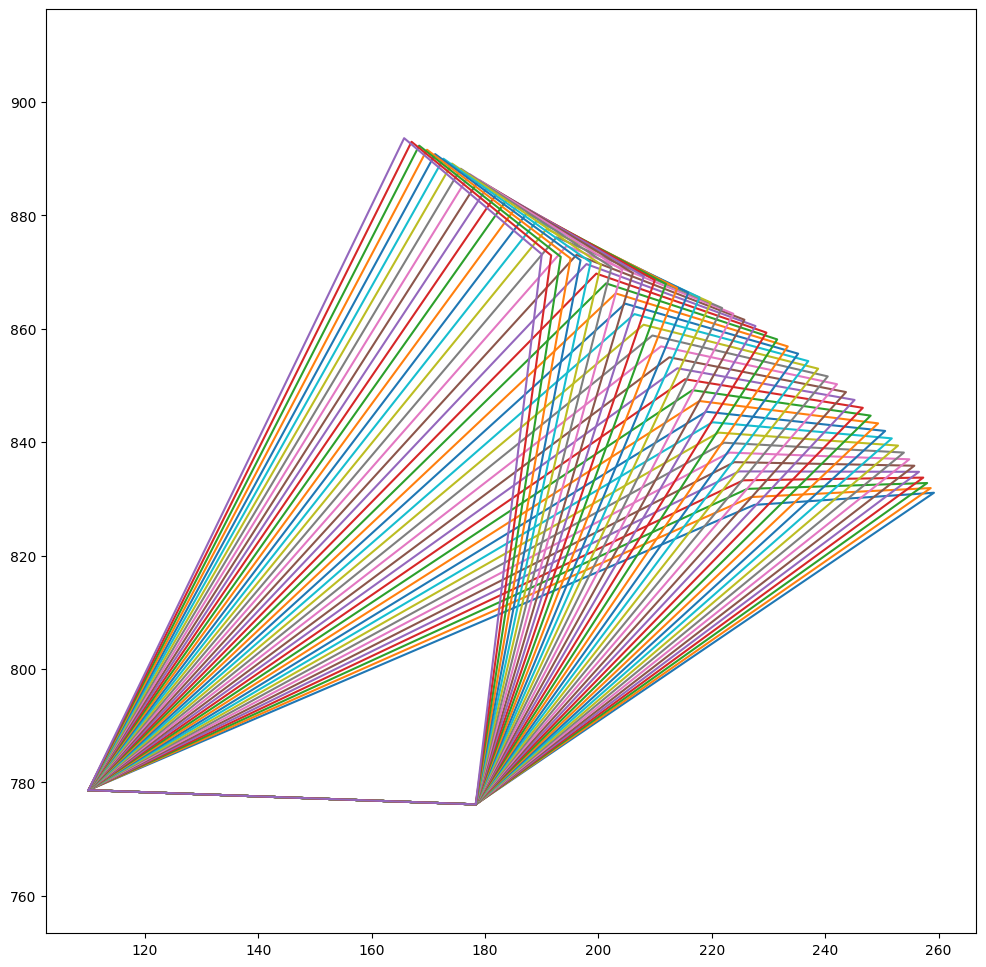

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
plt.axis('equal')
plt.plot(apx,apy)
#plt.plot(appx,appy)
#plt.plot(aqx,aqy)

In [ ]:
value_array_2 = value_arrays[number_of_trial].iloc[1:-1, 1:9]
value_array_2

,p1x,p1y,p2x,p2y,p3x,p3y,p4x,p4y
1,110.098478,778.418846,178.287865,775.971712,258.846385,830.764606,227.165393,829.223354
2,110.064519,778.616036,178.364873,776.100553,259.183719,831.069033,227.503516,828.927336
3,110.033406,778.750689,178.409632,776.195721,259.515096,831.337188,227.774550,828.636493
4,110.019319,778.895243,178.436729,776.286331,259.842199,831.614579,228.023396,828.350219
5,110.022531,779.036158,178.460748,776.372754,260.165969,831.902893,228.250973,828.068043
6,110.028650,779.174077,178.467325,776.440663,260.487206,832.174371,228.458151,827.789548
7,110.052388,779.309574,178.471238,776.504967,260.806692,832.459344,228.645642,827.514416
8,110.079240,779.443162,178.472609,776.565873,261.125179,832.744312,228.814027,827.242316
9,110.124281,779.560281,178.456552,776.608615,261.443326,833.030162,228.963750,826.987974
10,110.187914,779.691516,178.453126,776.663428,261.777092,833.333285,229.110638,826.736220


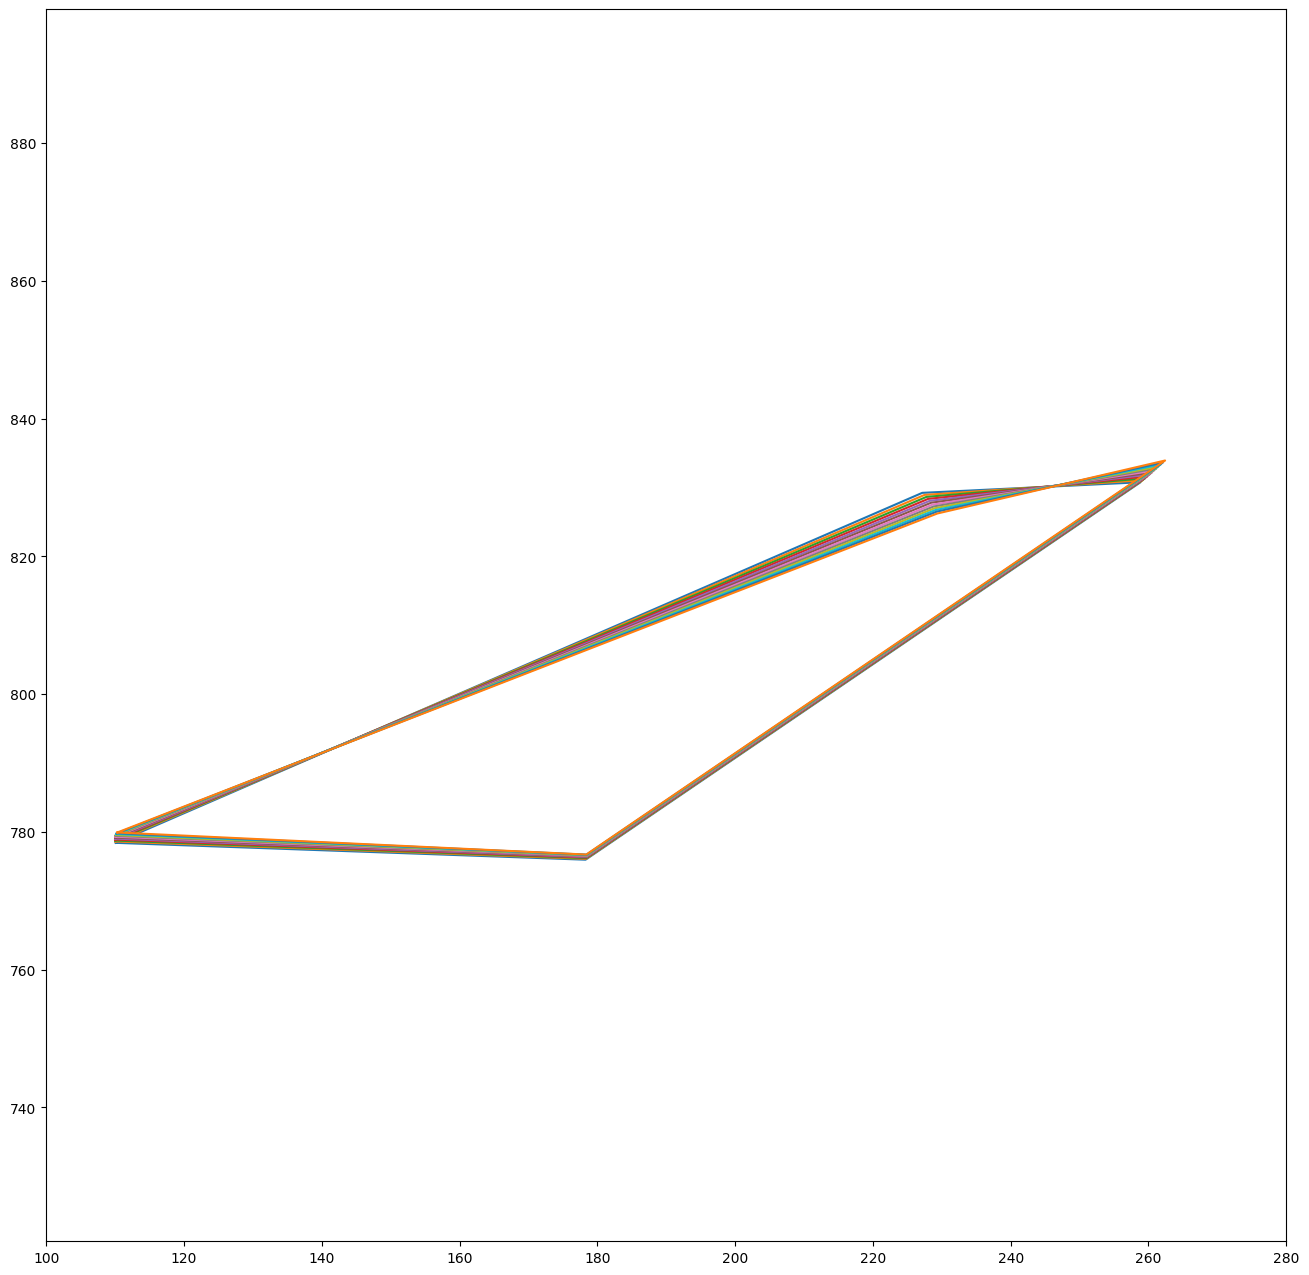

In [ ]:
plt.figure(figsize=(16, 16))
plt.axis('equal')
plt.xlim((100,280))
plt.ylim((760,860))
for n in range(12):
    xlist = value_array_2.iloc[n, [i%2 == 0 for i in range(len(value_array_2.columns))]].to_list()
    xlist.append(value_array_2.iloc[n,0])
    ylist = value_array_2.iloc[n, [i%2 == 1 for i in range(len(value_array_2.columns))]].to_list()
    ylist.append(value_array_2.iloc[n,1])

    plt.plot(xlist,ylist)